# Fitting SEIR model parameters

In [1]:
import numpy as np
import pandas as pd

#visualization library
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')

from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from hyperopt import fmin, rand, tpe, hp
from sklearn.cluster import KMeans
from sklearn import metrics

import json

params=['$w_1$', '$w_2$', '$w_3$', '$w_4$']
data='data/'
img='img/'
tmp='tmp/'
lib='dnn_opt_seir/bin/examples/seir/'

## Auxiliary functions

This section simply declare auxiliary functions to be used in the Notebook, it can be skipped.

### Plots ordinal axis in scientific notation

In [2]:
def update_label(old_label, exponent_text):
    if exponent_text == "":
        return old_label
    
    try:
        units = old_label[old_label.index("[") + 1:old_label.rindex("]")]
    except ValueError:
        units = ""
    label = old_label.replace("[{}]".format(units), "")
    
    exponent_text = exponent_text.replace("\\times", "")
    
    return "{} [{} {}]".format(label, exponent_text, units)
    
def format_axis(ax, axis='both'):
    
    """ Format the label string with the exponent from the ScalarFormatter """
    ax.ticklabel_format(axis=axis, style='sci')

    axes_instances = []
    if axis in ['x', 'both']:
        axes_instances.append(ax.xaxis)
    if axis in ['y', 'both']:
        axes_instances.append(ax.yaxis)
    
    for ax in axes_instances:
        ax.major.formatter._useMathText = True
        plt.draw() # Update the text
        exponent_text = ax.get_offset_text().get_text()
        label = ax.get_label().get_text()
        ax.offsetText.set_visible(False)
        ax.set_label_text(update_label(label, exponent_text))

### Interface to dnn_opt to use FA algorithm

In [3]:
import subprocess

def generate_swarm(dbi, dbr, s0=11000000, i0=3, population_count=1000, max_eval=1000, algorithm=1, odb=tmp+'fireflies.csv', time=50, model=0):
    result = subprocess.run([lib+'swarm', '-o', str(1),
                             '-p', str(population_count), '-eta', str(max_eval), '-a', str(algorithm), '-model', str(model),
                             '-odb', str(odb), '-db-i', str(dbi), '-db-r', str(dbr), '-time', str(time),
                             '-s0', str(s0), '-i0', str(i0)], 
                             stdout=subprocess.PIPE)
    
def get_quality(dbi, dbr, dbp, time=50, s0=11000000, i0=3, model=0):
    result = subprocess.run([lib+'quality',
                            '-db-i', str(dbi), '-db-r', str(dbr), '-time', str(time), '-model', str(model), '-db-p', str(dbp),
                            '-s0', str(s0), '-i0', str(i0)], 
                            stdout=subprocess.PIPE)
    return float(result.stdout)

def generate_history(dbp, time, s0=11000000, i0=3, odb=tmp+'history.csv', model=0):
    result = subprocess.run([lib+'history',
                            '-odb', str(odb), '-time', str(time), '-model', str(model), '-db-p', str(dbp),
                            '-s0', str(s0), '-i0', str(i0)], 
                            stdout=subprocess.PIPE)
    
    return result.stdout

## Data extraction

In [4]:
def extract_country_data(country):
    infected=[]
    recovered=[]

    with open('data/timeseries.json') as timeseries:
        fdata = json.load(timeseries)
        init=True
        for day in fdata[country]:
            if init==True and day['confirmed']!=0:
                init=False
            if init==False:
                infected.append(day['confirmed'] - day['recovered'] - day['deaths'])
                recovered.append(day['recovered'] + day['deaths'])

    df_infected=pd.DataFrame(columns=['Active infected'], data=infected)
    df_recovered=pd.DataFrame(columns=['Recovered'], data=recovered)
    
    df_infected.to_csv(data+country+'/infected.csv', sep=" ", index=None, header=False)
    df_recovered.to_csv(data+country+'/recovered.csv', sep=" ", index=None, header=False)
    
    df_infected.columns=['Active infected']
    df_recovered.columns=['Recovered']
    
    return (df_infected, df_recovered)

### Post-processing of FA swarms

In [5]:
def get_clusters(model, swarms_count, file_base_name, dbi, dbr, s0):
    top_clusters=np.array([])
    top_fitness=np.array([])
    param_count=4

    for fa in range(0, swarms_count):
        df_fire=pd.read_csv(tmp+country+file_base_name+str(fa)+'.csv')
        param_count=df_fire.shape[1]

        models =[]
        for i in range(10, 100, 10):
            clustering=KMeans(n_clusters=i)
            models.append(clustering.fit(df_fire.values))

        sc=[]
        for model, i in zip(models, range(10, 100, 10)):
            sc.append(metrics.silhouette_score(df_fire.values, model.labels_, metric='euclidean'))

        best_cluster=sc.index(np.max(sc))
        centroids=models[best_cluster].cluster_centers_
        closest, _=metrics.pairwise_distances_argmin_min(centroids, df_fire.values)
        centroids=df_fire.values[closest]

        quality=[]
        for model_params in centroids:
            np.savetxt(tmp+"params.csv", model_params, delimiter=" ")
            f=get_quality(dbi, dbr, tmp+'params.csv', model=model, s0=s0)
            quality.append(f)

        quality=np.array(quality)
        best_idx=np.argsort(quality)

        quality=quality[best_idx]
        centroids=centroids[best_idx]

        distance=[1.0]
        for i in range(1, len(centroids)):
            sum=0.0
            for j in range(0, i):
                sum+=np.linalg.norm(centroids[i] - centroids[j]) #this is the euclidean distance
            sum/=i
            distance.append(sum)

        fitness=np.divide(quality, distance)
        order=np.argsort(fitness)

        top_1=order[0]
        top_2=order[1]
        top_3=order[2]
        top_4=order[3]

        swarm_top=np.array([centroids[top_1], centroids[top_2], centroids[top_3], centroids[top_4]])
        swarm_fitenss=np.array([fitness[top_1], fitness[top_2], fitness[top_3], fitness[top_4]])

        top_clusters=np.append(top_clusters, swarm_top)
        top_fitness=np.append(top_fitness, swarm_fitenss)

    top_clusters=top_clusters.reshape((swarms_count * 4, param_count))
    clustering=KMeans(n_clusters=4)
    model=clustering.fit(top_clusters)

    df_A = pd.DataFrame(data=top_clusters[model.labels_==0])
    df_B = pd.DataFrame(data=top_clusters[model.labels_==1])
    df_C = pd.DataFrame(data=top_clusters[model.labels_==2])
    df_D = pd.DataFrame(data=top_clusters[model.labels_==3])
    
    f_A=np.mean(top_fitness[model.labels_==0])
    f_B=np.mean(top_fitness[model.labels_==1])
    f_C=np.mean(top_fitness[model.labels_==2])
    f_D=np.mean(top_fitness[model.labels_==3])
    
    groups=[df_A, df_B, df_C, df_D]
    fitness=np.array([f_A, f_B, f_C, f_D])
    order=np.argsort(fitness)
    
    top_1=order[0]
    top_2=order[1]
    top_3=order[2]
    top_4=order[3]
    
    return [groups[top_1], groups[top_2], groups[top_3], groups[top_4]]

### Plot functions

In [6]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 16})

In [7]:
def show_results(groups, df_real_infected, df_real_recovered, day_count, model, base_name, s0, titles=['A', 'B', 'C', 'D']):
    x=np.linspace(0, day_count, day_count)
    infected=[]
    recovered=[]
    beta=[]
    
    for df_group in groups:
        infected.append(pd.DataFrame(index=range(0, day_count), columns=df_group.index))
        recovered.append(pd.DataFrame(index=range(0, day_count), columns=df_group.index))
        beta.append(pd.DataFrame(index=range(0, day_count), columns=df_group.index))

    for df_infected, df_recovered, df_beta, df_group in zip(infected, recovered, beta, groups):
        for idx, model_params in df_group.iterrows():
            np.savetxt(tmp+"params.csv", model_params, delimiter=" ")
                             
            generate_history(tmp+"params.csv", time=day_count, model=model, odb=tmp+'history.csv', s0=s0)
            history=pd.read_csv(tmp+'history.csv', header=None)
            history.columns=['s', 'e', 'i', 'r', 'b']

            df_infected[idx]=history['i']
            df_recovered[idx]=history['r']
            df_beta[idx]=history['b']
    
    for df_infected, df_recovered, df_group in zip(infected, recovered, groups):
        df_infected['mean']=df_infected[df_group.index].mean(axis=1)
        df_infected['std']=df_infected[df_group.index].std(axis=1)
                                  
        df_recovered['mean']=df_recovered[df_group.index].mean(axis=1)
        df_recovered['std']=df_recovered[df_group.index].std(axis=1)
                                  
    fig, ax = plt.subplots(2, 4, figsize=(20, 6), sharey=False)
    fig.tight_layout()
    
    # Plot the infected time series from day one to the last day
    for df_infected, title, axis in zip(infected, titles, ax[0]):
        df_infected['mean'].plot(kind='line', ax=axis, legend=False, color='black', title=title)
        axis.fill_between(df_infected.index, df_infected['mean'] - df_infected['std'], df_infected['mean'] + df_infected['std'])
        df_real_infected.plot.line(legend=True, color='b', ax=axis)
        axis.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axis.set_ylabel("Cases")
        format_axis(axis, axis='y')
     
    # Plot beta value in time
    for df_beta, title, axis in zip(beta, titles, ax[1]):
        df_beta.plot(kind='line', ax=axis, legend=False, color='black', alpha=0.2, title=title)
        axis.set_ylabel(r"$\beta_"+str(model+1)+"(t)$")

    fig.savefig(img+country+base_name+'forecast.pdf',bbox_inches='tight')
    fig, ax = plt.subplots(2, 4, figsize=(20, 6), sharey=False)
    fig.tight_layout()
    
    # Plot the infected time series vs real time series with zoom
    for df_infected, title, axis in zip(infected, titles, ax[0]):
        df_infected['mean'].plot(kind='line', ax=axis, legend=False, color='black', title=title)
        axis.fill_between(df_infected.index, df_infected['mean'] - df_infected['std'], df_infected['mean'] + df_infected['std'])
        df_real_infected.plot.line(legend=True, color='b', ax=axis)
        axis.set_xlim(0, 50)
        axis.set_ylim(0, 1000)
        axis.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axis.set_ylabel("Cases")
        format_axis(axis, axis='y')
    
    # Plot the recovered time series vs real time series with zoom
    for df_recovered, title, axis in zip(recovered, titles, ax[1]):
        df_recovered['mean'].plot(kind='line', ax=axis, legend=False, color='black', title=title)
        axis.fill_between(df_recovered.index, df_recovered['mean'] - df_recovered['std'], df_recovered['mean'] + df_recovered['std'])
        df_real_recovered.plot.line(legend=True, color='b', ax=axis)
        axis.set_xlim(0, 50)
        axis.set_ylim(0, 1000)
        axis.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axis.set_ylabel("Cases")
        format_axis(axis, axis='y')

    fig.savefig(img+country+base_name+'fit.pdf',bbox_inches='tight')
    fig, ax = plt.subplots(1, 4, figsize=(20, 3), sharey=False)
    fig.tight_layout()
    params=[i for i in range(0, 2)]
    
    # Plot SEIR parameters distribution in box plot
    for df_group, title, axis in zip(groups, titles, ax):
        df_group[params].rename(columns={0: r'$\gamma_0$', 1: r'$\gamma_1$'}).plot(kind='box', ax=axis, showmeans=False, title=title)

    fig.savefig(img+country+base_name+'parameters.pdf',bbox_inches='tight')
    
def show_data(df_infected, df_recovered, base_name='timeseries'):
    fig, ax = plt.subplots(1, 2, figsize=(20,5)) 

    infected_plot=df_infected.plot(kind='line', ax=ax[0], legend=True, color='black')
    recovered_plot=df_recovered.plot(kind='line', ax=ax[1], legend=True, color='black')

    infected_plot.set_xlabel("Number of days")
    infected_plot.set_ylabel("Number of patients")

    recovered_plot.set_xlabel("Number of days")
    recovered_plot.set_ylabel("Number of patients")

    fig.savefig(img+country+base_name+'.pdf', bbox_inches='tight')

## Finding local minima of SEIR model that fits observed data

Here we will find for several SEIR models that fits oberved infected/recovered data. We study three scenarios:

1. Relaxing social distancing policies. The social distancing policies are reduced during the begining of the epidemic via public health interventions and other policies. After this, such social distance measures are relaxed.

2. Keeping social distancing policies as it is. The social distancing policies are kept just as they are right now.

3. Relaxing and hardering social distance policies. Social distance policies are relaxed and hardened periodically.

## Cuba data

In this section we perform an analysis of Cuban data.

In [8]:
country='Cuba'

df_infected, df_recovered=extract_country_data(country)

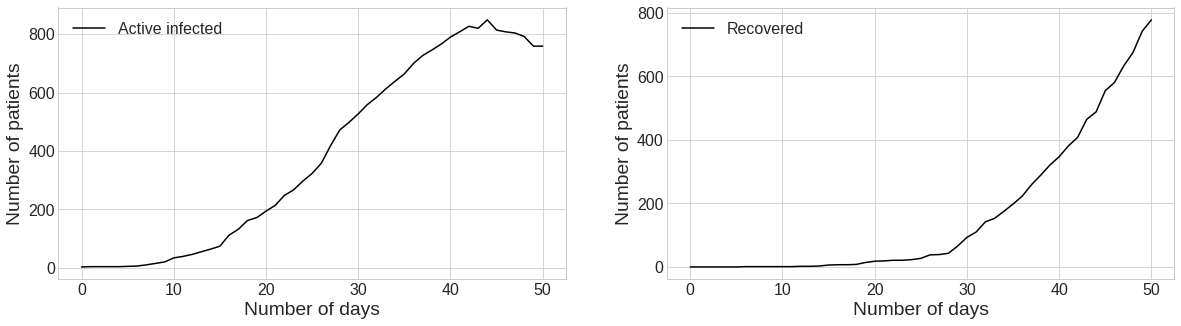

In [9]:
show_data(df_infected, df_recovered)

### Scenario 1: Relaxing social distance policies

In [10]:
base_name_s1='scenario_1'

In [11]:
for i in range(0, 10):
    print("\r Progress: "+str(i * 10 + 10), end="%")
    generate_swarm(s0=11000000, max_eval=200, population_count=400, model=0, time=50, odb=tmp+country+base_name_s1+str(i)+'.csv', dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

 Progress: 100%

In [12]:
groups_s1=get_clusters(s0=11000000, model=0, swarms_count=10, file_base_name=base_name_s1, dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

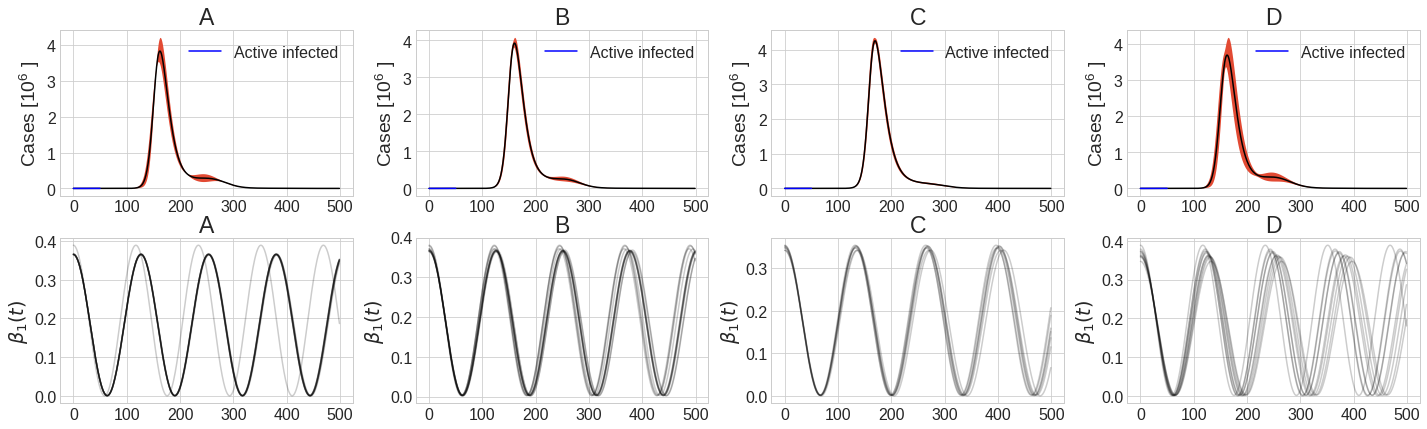

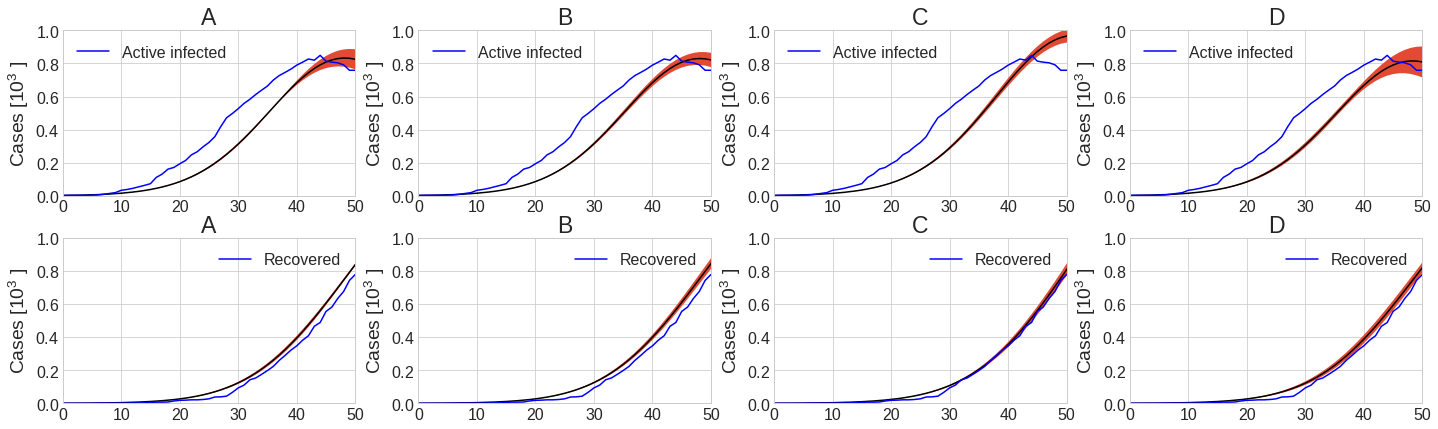

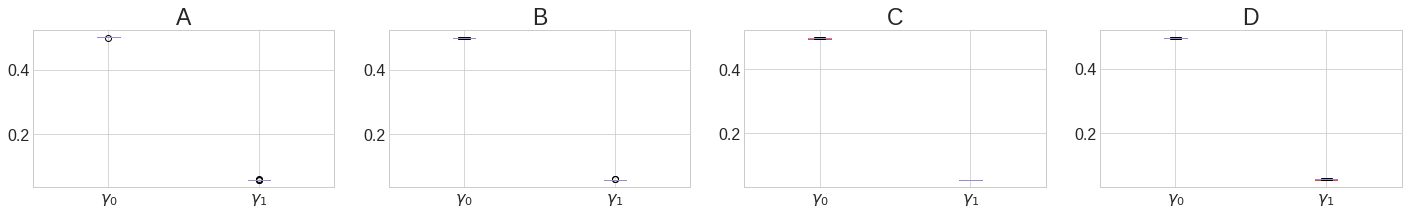

In [13]:
show_results( groups_s1, df_infected, df_recovered, day_count=500, model=0, s0=11000000, base_name=base_name_s1)

### Scenario 2: Keeping social distance policies as they are

In [14]:
base_name_s2='scenario_2'

In [15]:
for i in range(0, 10):
    print("\r Progress: "+str(i * 10 + 10), end="%")
    generate_swarm(s0=11000000, max_eval=200, population_count=400, model=1, time=50, odb=tmp+country+base_name_s2+str(i)+'.csv', dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

 Progress: 100%

In [16]:
groups_s2=get_clusters(s0=11000000, model=1, swarms_count=10, file_base_name=base_name_s2, dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

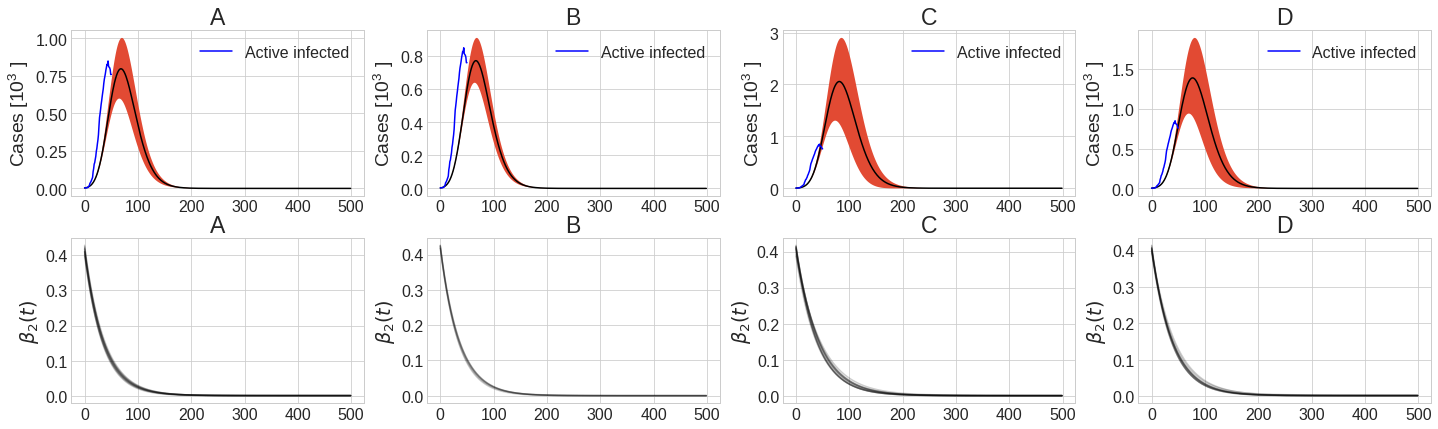

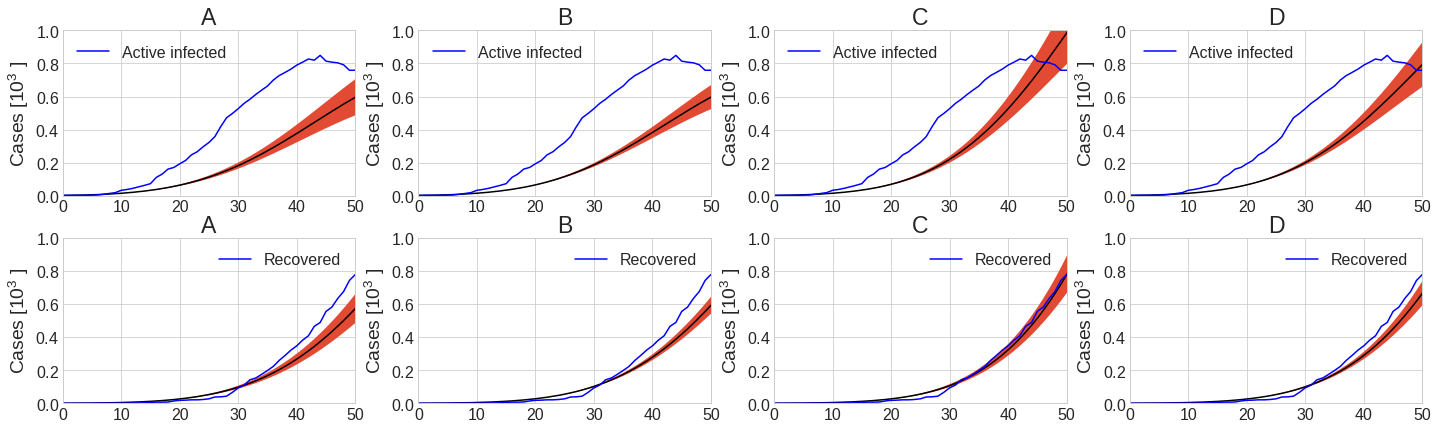

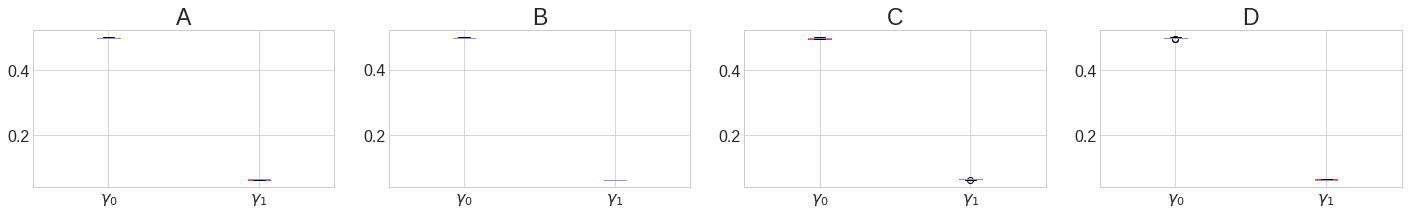

In [17]:
show_results(groups_s2, df_infected, df_recovered, day_count=500, model=1, s0=11000000, base_name=base_name_s2)

### Scenario 3: 

In [18]:
base_name_s3='scenario_3'

In [19]:
for i in range(0, 10):
    print("\r Progress: "+str(i * 10 + 10), end="%")
    generate_swarm(s0=11000000, max_eval=200, population_count=400, model=2, time=50, odb=tmp+country+base_name_s3+str(i)+'.csv', dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

 Progress: 100%

In [20]:
groups_s3=get_clusters(s0=11000000, model=2, swarms_count=10, file_base_name=base_name_s3, dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

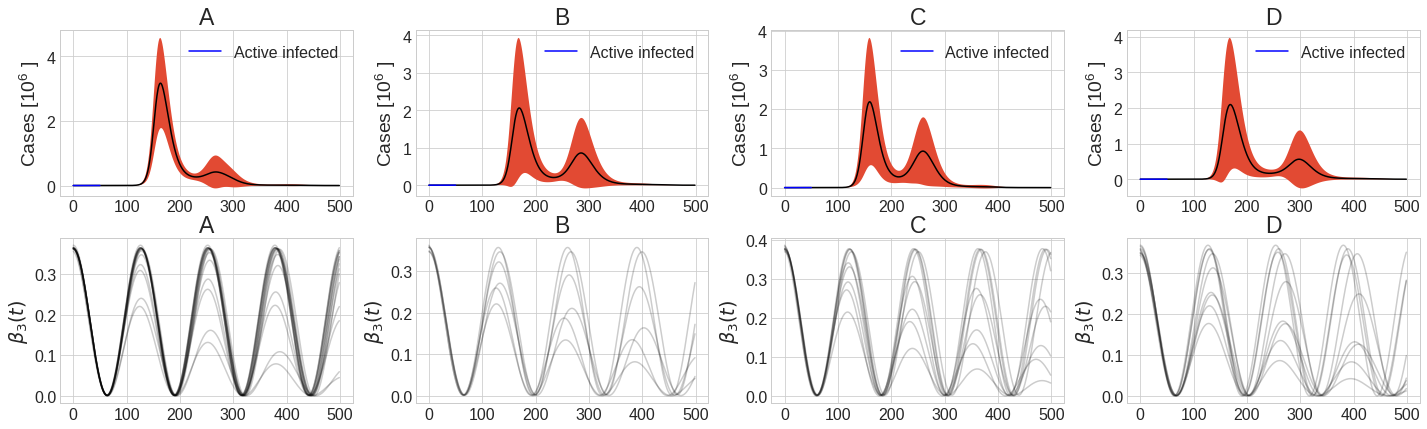

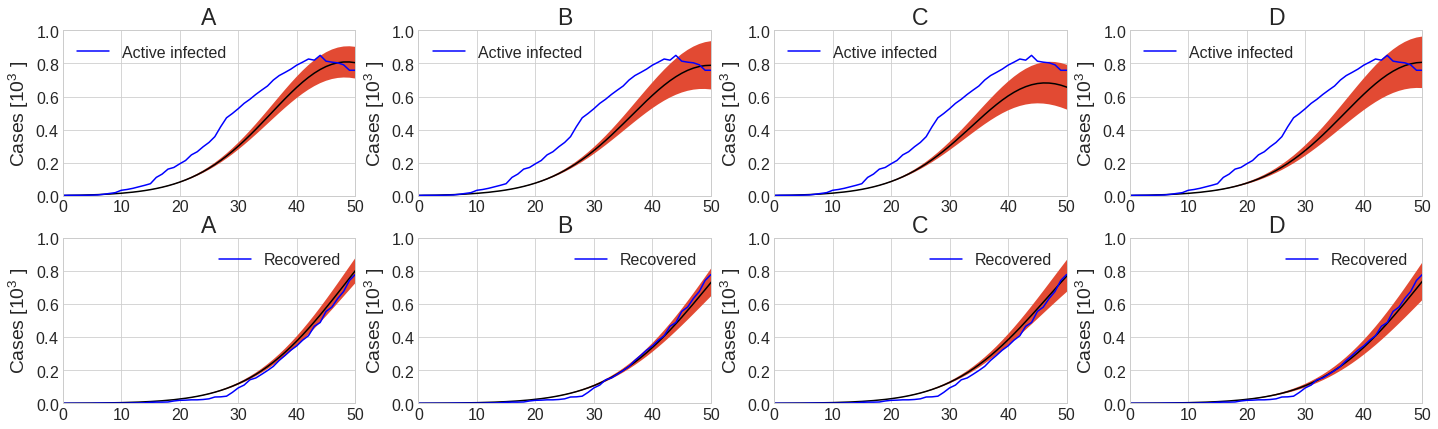

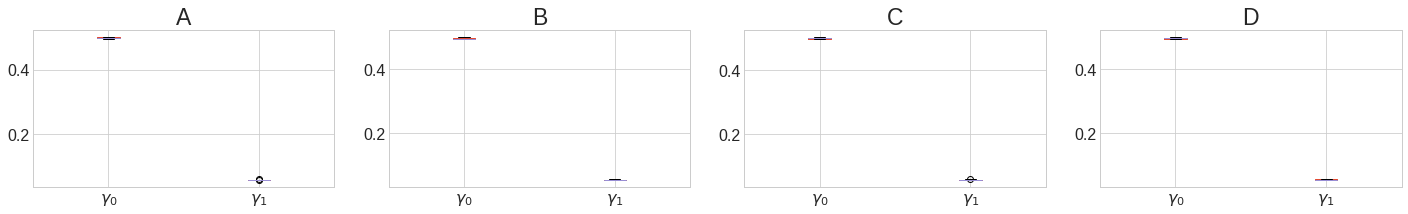

In [21]:
show_results(groups_s3, df_infected, df_recovered, day_count=500, model=2, s0=11000000, base_name=base_name_s3)

## Spain data

In this section we perform an analysis of Spain data.

In [22]:
country='Spain'

df_infected, df_recovered=extract_country_data(country)

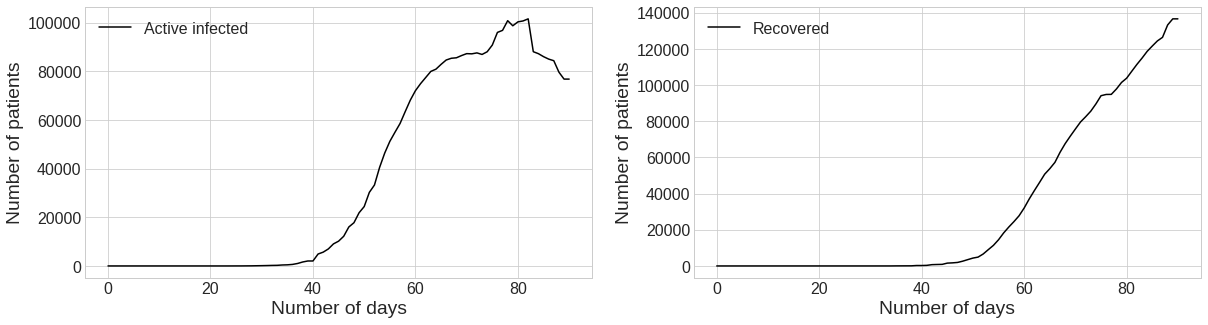

In [23]:
show_data(df_infected, df_recovered)

### Scenario 1: Relaxing social distance policies

In [24]:
base_name_s1='scenario_1'

In [25]:
for i in range(0, 10):
    print("\r Progress: "+str(i * 10 + 10), end="%")
    generate_swarm(s0=46940000, max_eval=200, population_count=400, model=0, time=50, odb=tmp+country+base_name_s1+str(i)+'.csv', dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

 Progress: 100%

In [26]:
groups_s1=get_clusters(s0=46940000, model=0, swarms_count=10, file_base_name=base_name_s1, dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

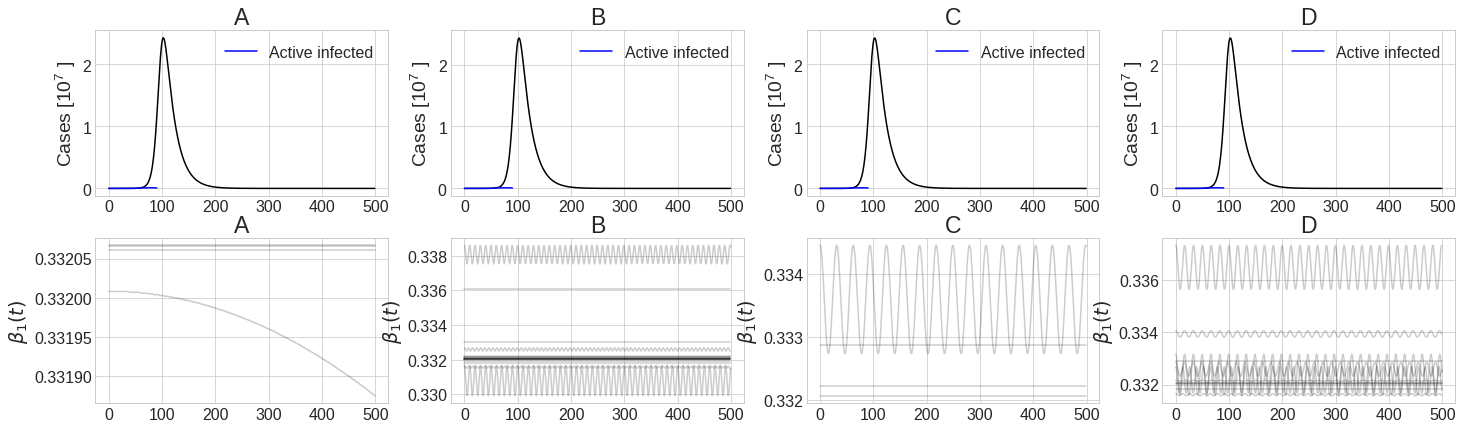

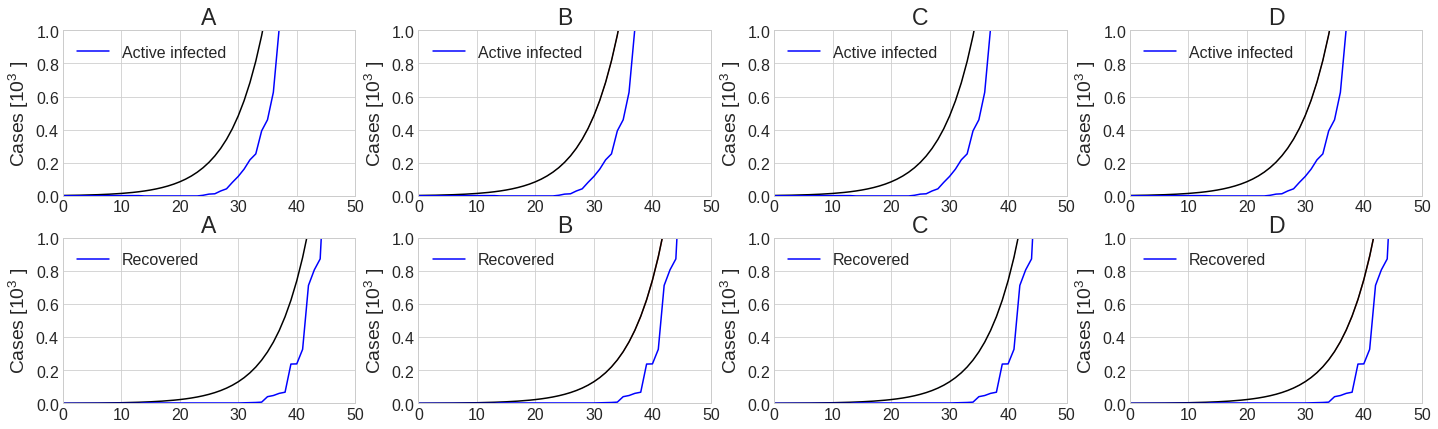

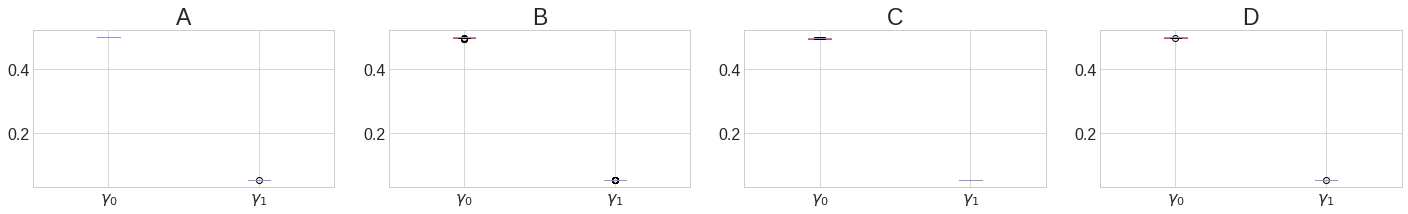

In [27]:
show_results(groups_s1, df_infected, df_recovered, day_count=500, model=0, s0=46940000, base_name=base_name_s1)

### Scenario 2: Keeping social distance policies as they are

In [28]:
base_name_s2='scenario_2'

In [29]:
for i in range(0, 10):
    print("\r Progress: "+str(i * 10 + 10), end="%")
    generate_swarm(s0=46940000, max_eval=200, population_count=400, model=1, time=50, odb=tmp+country+base_name_s2+str(i)+'.csv', dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

 Progress: 100%

In [30]:
groups_s2=get_clusters(s0=46940000, model=1, swarms_count=10, file_base_name=base_name_s2, dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

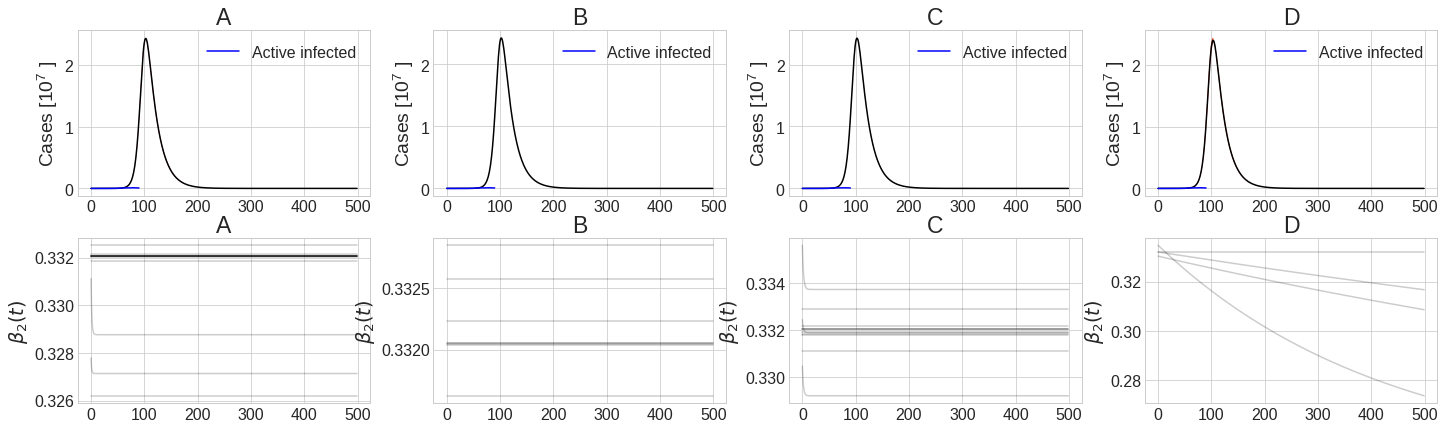

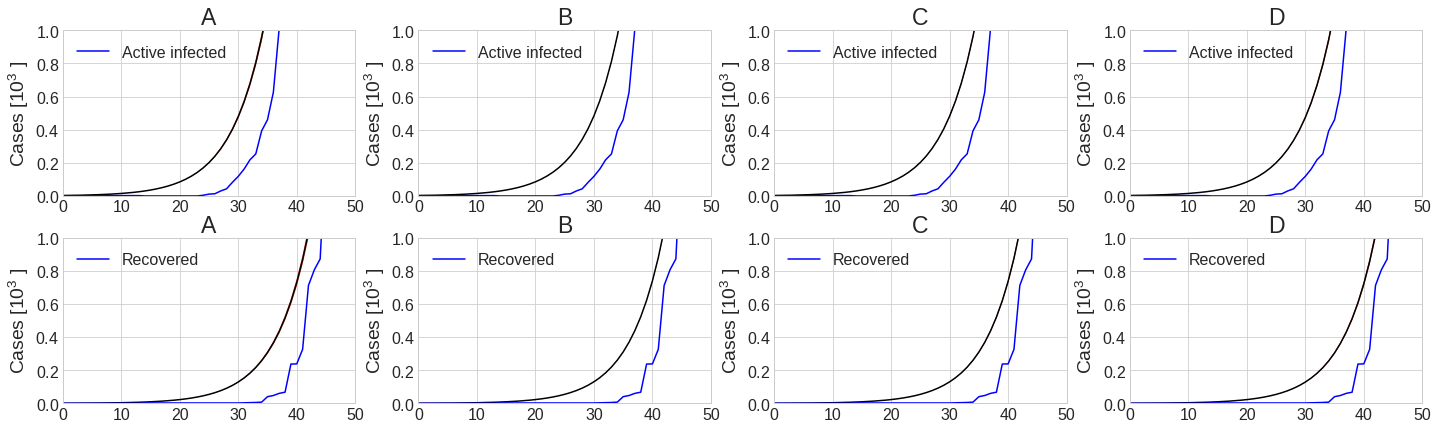

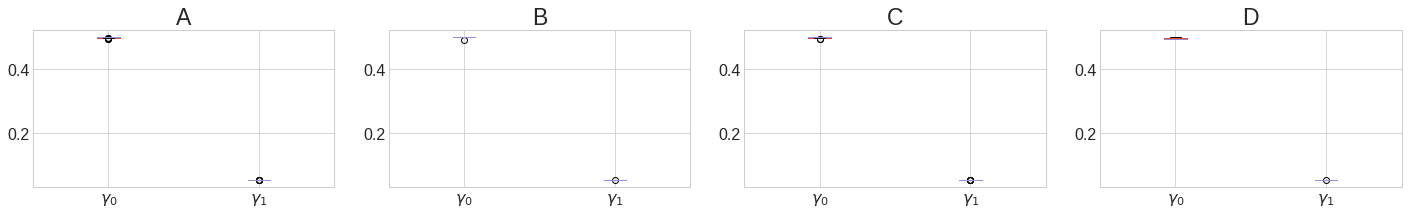

In [31]:
show_results(groups_s2, df_infected, df_recovered, day_count=500, model=1, s0=46940000, base_name=base_name_s2)

### Scenario 3: 

In [32]:
base_name_s3='scenario_3'

In [33]:
for i in range(0, 10):
    print("\r Progress: "+str(i * 10 + 10), end="%")
    generate_swarm(s0=46940000, max_eval=200, population_count=400, model=2, time=50, odb=tmp+country+base_name_s3+str(i)+'.csv', dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

 Progress: 100%

In [34]:
groups_s3=get_clusters(s0=46940000, model=2, swarms_count=10, file_base_name=base_name_s3, dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

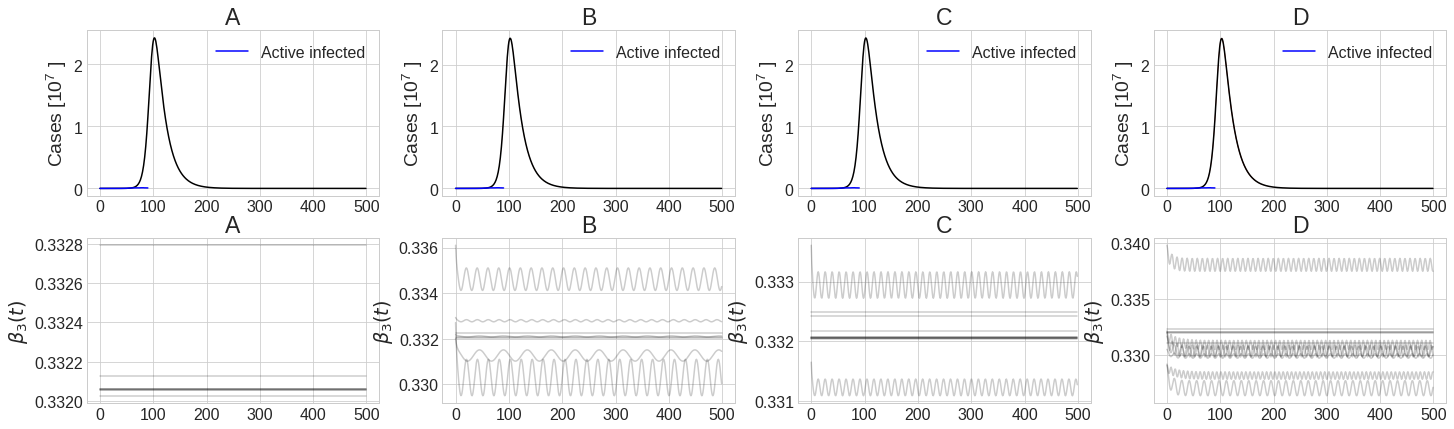

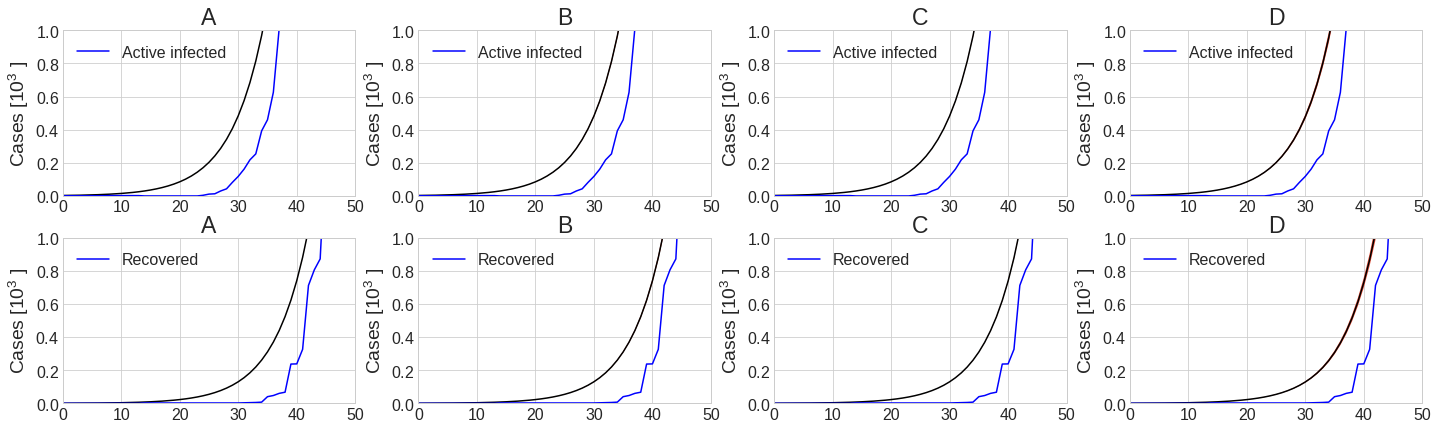

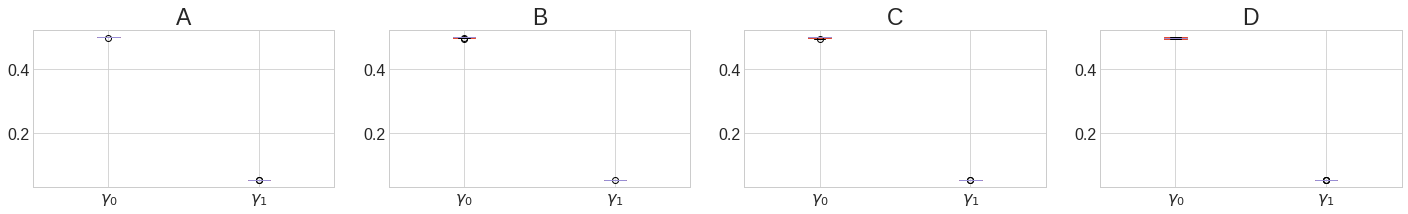

In [35]:
show_results(groups_s3, df_infected, df_recovered, day_count=500, model=2, s0=46940000, base_name=base_name_s3)

## Italy data

In this section we perform an analysis of Italy data.

In [8]:
country='Italy'

df_infected, df_recovered=extract_country_data(country)

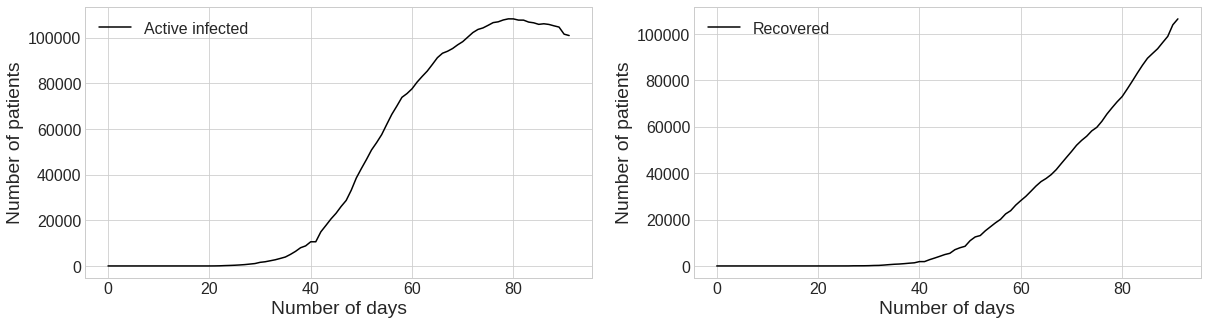

In [9]:
show_data(df_infected, df_recovered)

### Scenario 1: Relaxing social distance policies

In [10]:
base_name_s1='scenario_1'

In [11]:
for i in range(0, 10):
    print("\r Progress: "+str(i * 10 + 10), end="%")
    generate_swarm(s0=60360000, max_eval=200, population_count=400, model=0, time=50, odb=tmp+country+base_name_s1+str(i)+'.csv', dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

 Progress: 100%

In [12]:
groups_s1=get_clusters(s0=60360000, model=0, swarms_count=10, file_base_name=base_name_s1, dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

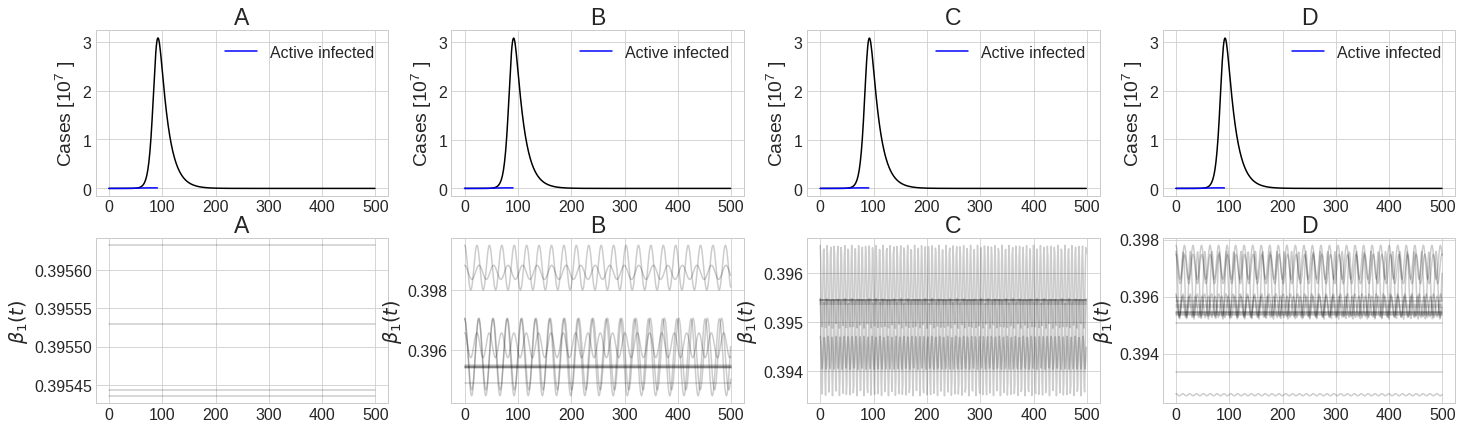

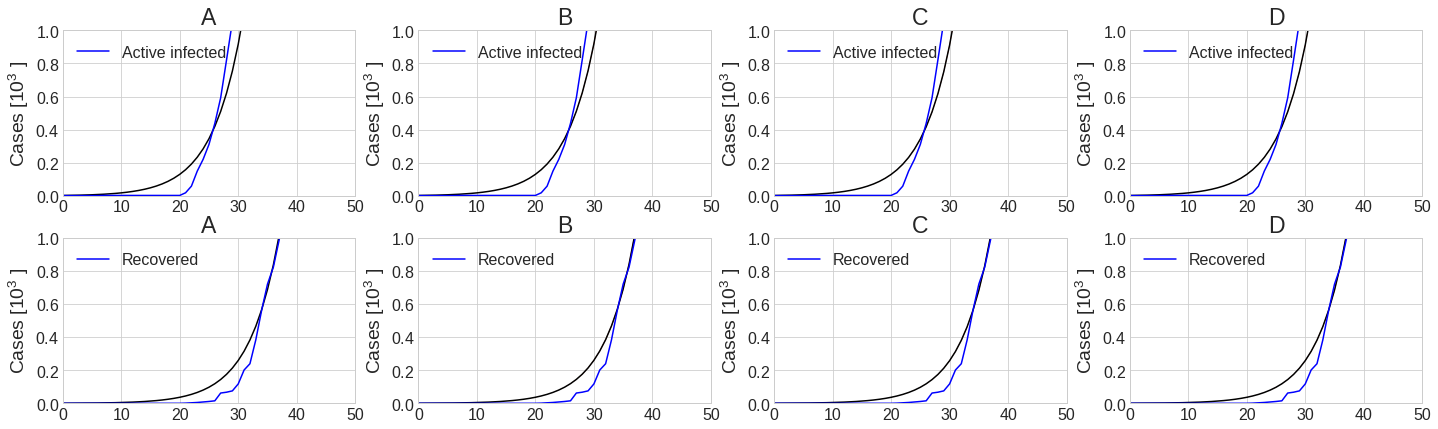

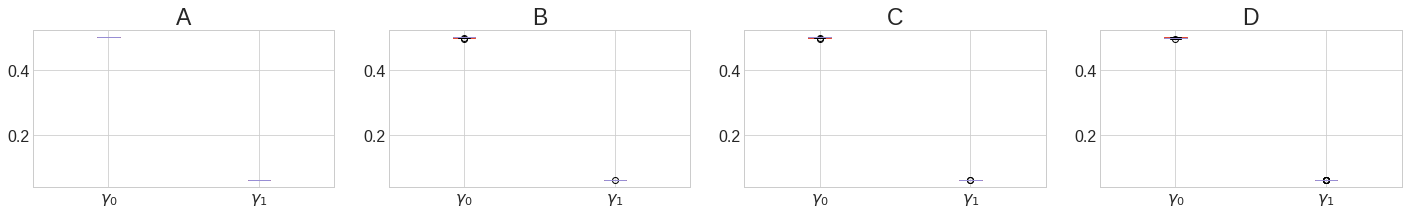

In [13]:
show_results(groups_s1, df_infected, df_recovered, day_count=500, model=0, s0=60360000, base_name=base_name_s1)

### Scenario 2: Keeping social distance policies as they are

In [14]:
base_name_s2='scenario_2'

In [15]:
for i in range(0, 10):
    print("\r Progress: "+str(i * 10 + 10), end="%")
    generate_swarm(s0=60360000, max_eval=200, population_count=400, model=1, time=50, odb=tmp+country+base_name_s2+str(i)+'.csv', dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

 Progress: 100%

In [16]:
groups_s2=get_clusters(s0=60360000, model=1, swarms_count=10, file_base_name=base_name_s2, dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

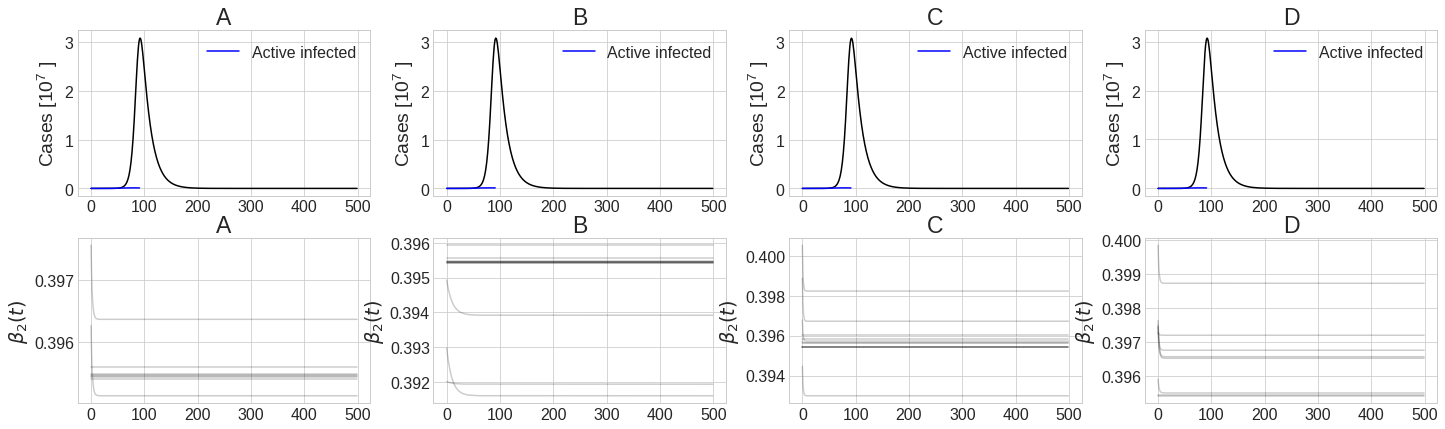

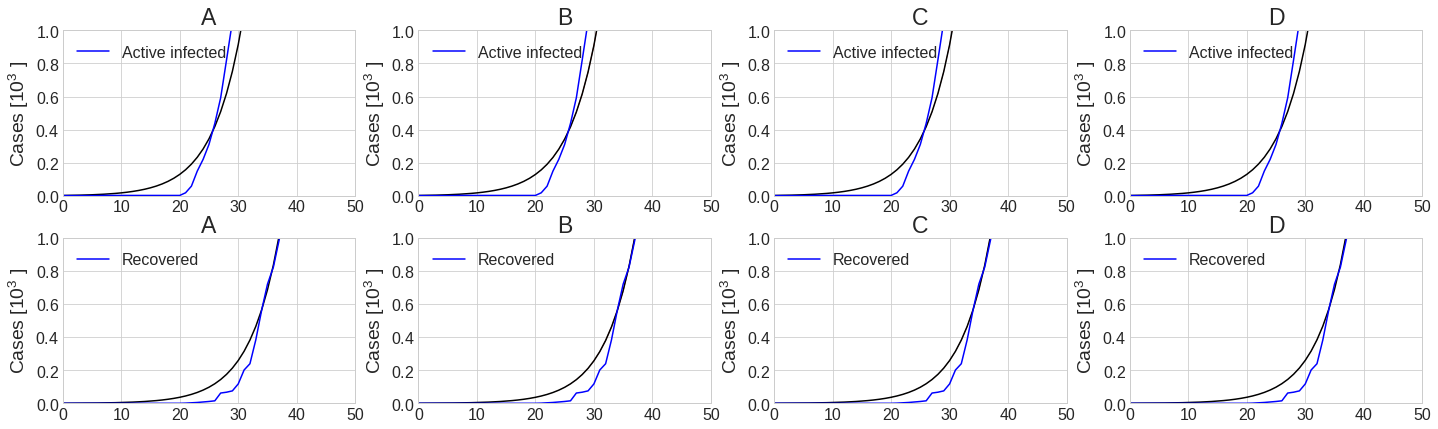

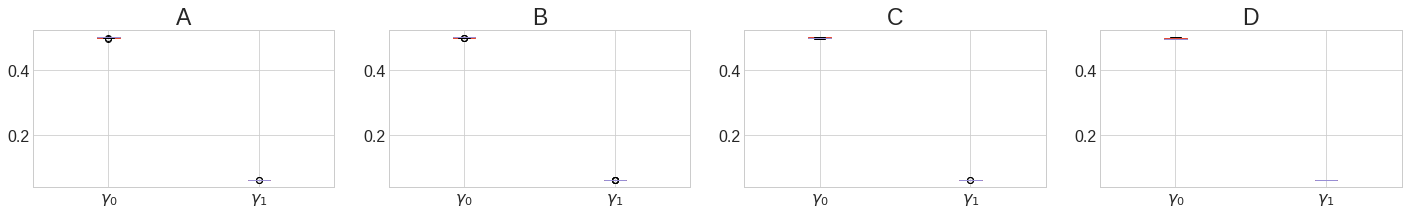

In [17]:
show_results(groups_s2, df_infected, df_recovered, day_count=500, model=1, s0=60360000, base_name=base_name_s2)

### Scenario 3: 

In [18]:
base_name_s3='scenario_3'

In [19]:
for i in range(0, 10):
    print("\r Progress: "+str(i * 10 + 10), end="%")
    generate_swarm(s0=60360000, max_eval=200, population_count=400, model=2, time=50, odb=tmp+country+base_name_s3+str(i)+'.csv', dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

 Progress: 100%

In [20]:
groups_s3=get_clusters(s0=60360000, model=2, swarms_count=10, file_base_name=base_name_s3, dbi=data+country+'/infected.csv', dbr=data+country+'/recovered.csv')

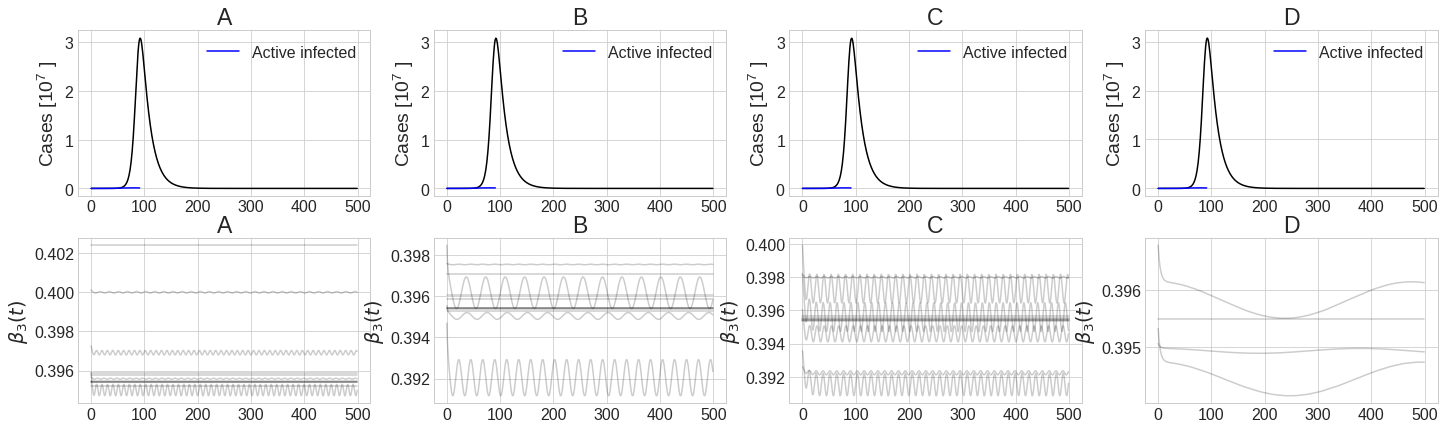

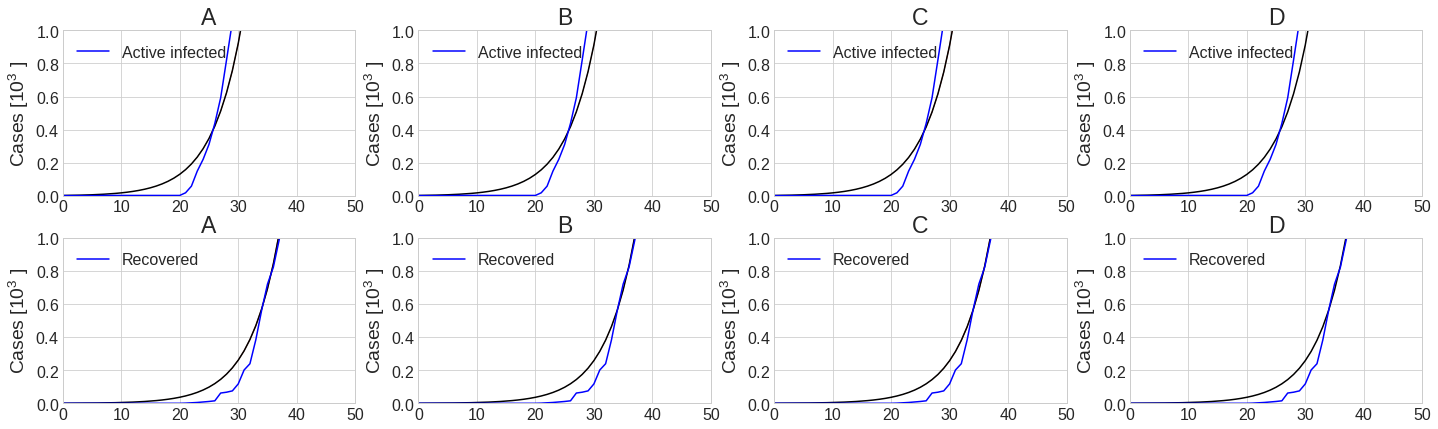

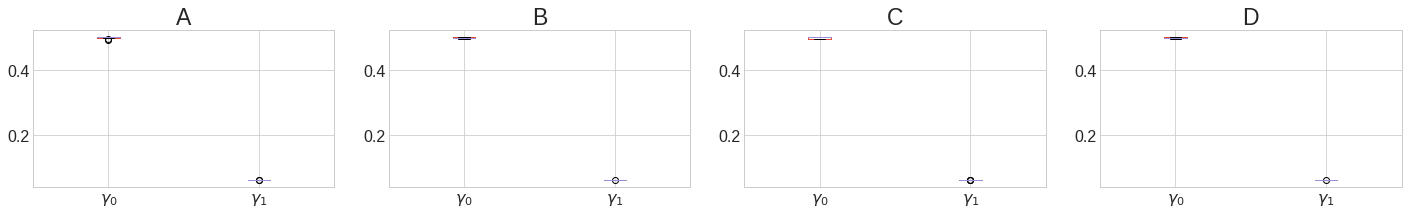

In [21]:
show_results(groups_s3, df_infected, df_recovered, day_count=500, model=2, s0=60360000, base_name=base_name_s3)